<a href="https://colab.research.google.com/drive/1Ss7QNdkJ1OnQAtso-pXXp4scU7ED3rn4">Abre este Jupyter en Google Colab</a>

# Caso Práctico: KMEANS

## Conjunto de datos: Detección de transacciones bancarias fraudulentas

### Descripción

Tendremos transacciones bancarias con tarjetas en septiembre de 2013. Está bastante descompensado. Este conjunto de datos se ha anonimizado. Es un conjunto de datos etiquetado. Toma el valor 1 en caso de fraude y 0 en caso de transacción legítima.

Se le ha aplicado un algoritmo PCA por lo que todo está en el mismo rango y se han optimizado las variables y son numéricas. Salvo dos atributos Time y amount que no están escalados (no tienen aplicado el algoritmo PCA). Time contiene en segundos el tiempo que ha pasado entre la primera y amount la cantidad de dinero... tendremos que ver si escalamos o normalizamos estos datos...o eliminarlas.


The datasets contains transactions made by credit cards in September 2013 by european cardholders. 
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Descarga de los ficheros de datos
https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv

### Referencias adicionales sobre el conjunto de datos
_The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project._

## Imports

In [40]:
# Instalamos seaborn
!pip install seaborn

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from collections import Counter
from sklearn import metrics
import numpy as np

In [42]:
import warnings
# Ignoramos algunos warnings que se producen por invocar el modelo sin el nombre de las características
warnings.filterwarnings('ignore', category=UserWarning, message='.*X does not have valid feature names.*')

## Funciones auxiliares

In [43]:
# Original code: https://bit.ly/2TNHBZ5
def plot_data(X, y):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'k.', markersize=2)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'r.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, y, resolution=1000, show_centroids=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X, y)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

In [44]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

## 1. Lectura del conjunto de datos

In [45]:
df = pd.read_csv("datasets/creditcard.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/creditcard.csv'

## 2. Visualización del conjunto de datos

In [46]:
df.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
5,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,0
6,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,0
7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0
8,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0
9,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,0


In [47]:
print("Número de características:", len(df.columns))
print("Longitud del conjunto de datos:", len(df))

Número de características: 29
Longitud del conjunto de datos: 284807


In [48]:
# 492 transacciones fraudulentas, 284315 transacciones legitimas
# El conjunto de datos se encuentra altamente desequilabrado
df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [49]:
# Visualizamos los tipos de cada uno de los atributos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 29 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

In [50]:
# Comprobamos si alguna columna tiene valores nulos
df.isna().any()

V1       False
V2       False
V3       False
V4       False
V5       False
V6       False
V7       False
V8       False
V9       False
V10      False
V11      False
V12      False
V13      False
V14      False
V15      False
V16      False
V17      False
V18      False
V19      False
V20      False
V21      False
V22      False
V23      False
V24      False
V25      False
V26      False
V27      False
V28      False
Class    False
dtype: bool

In [51]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.000000


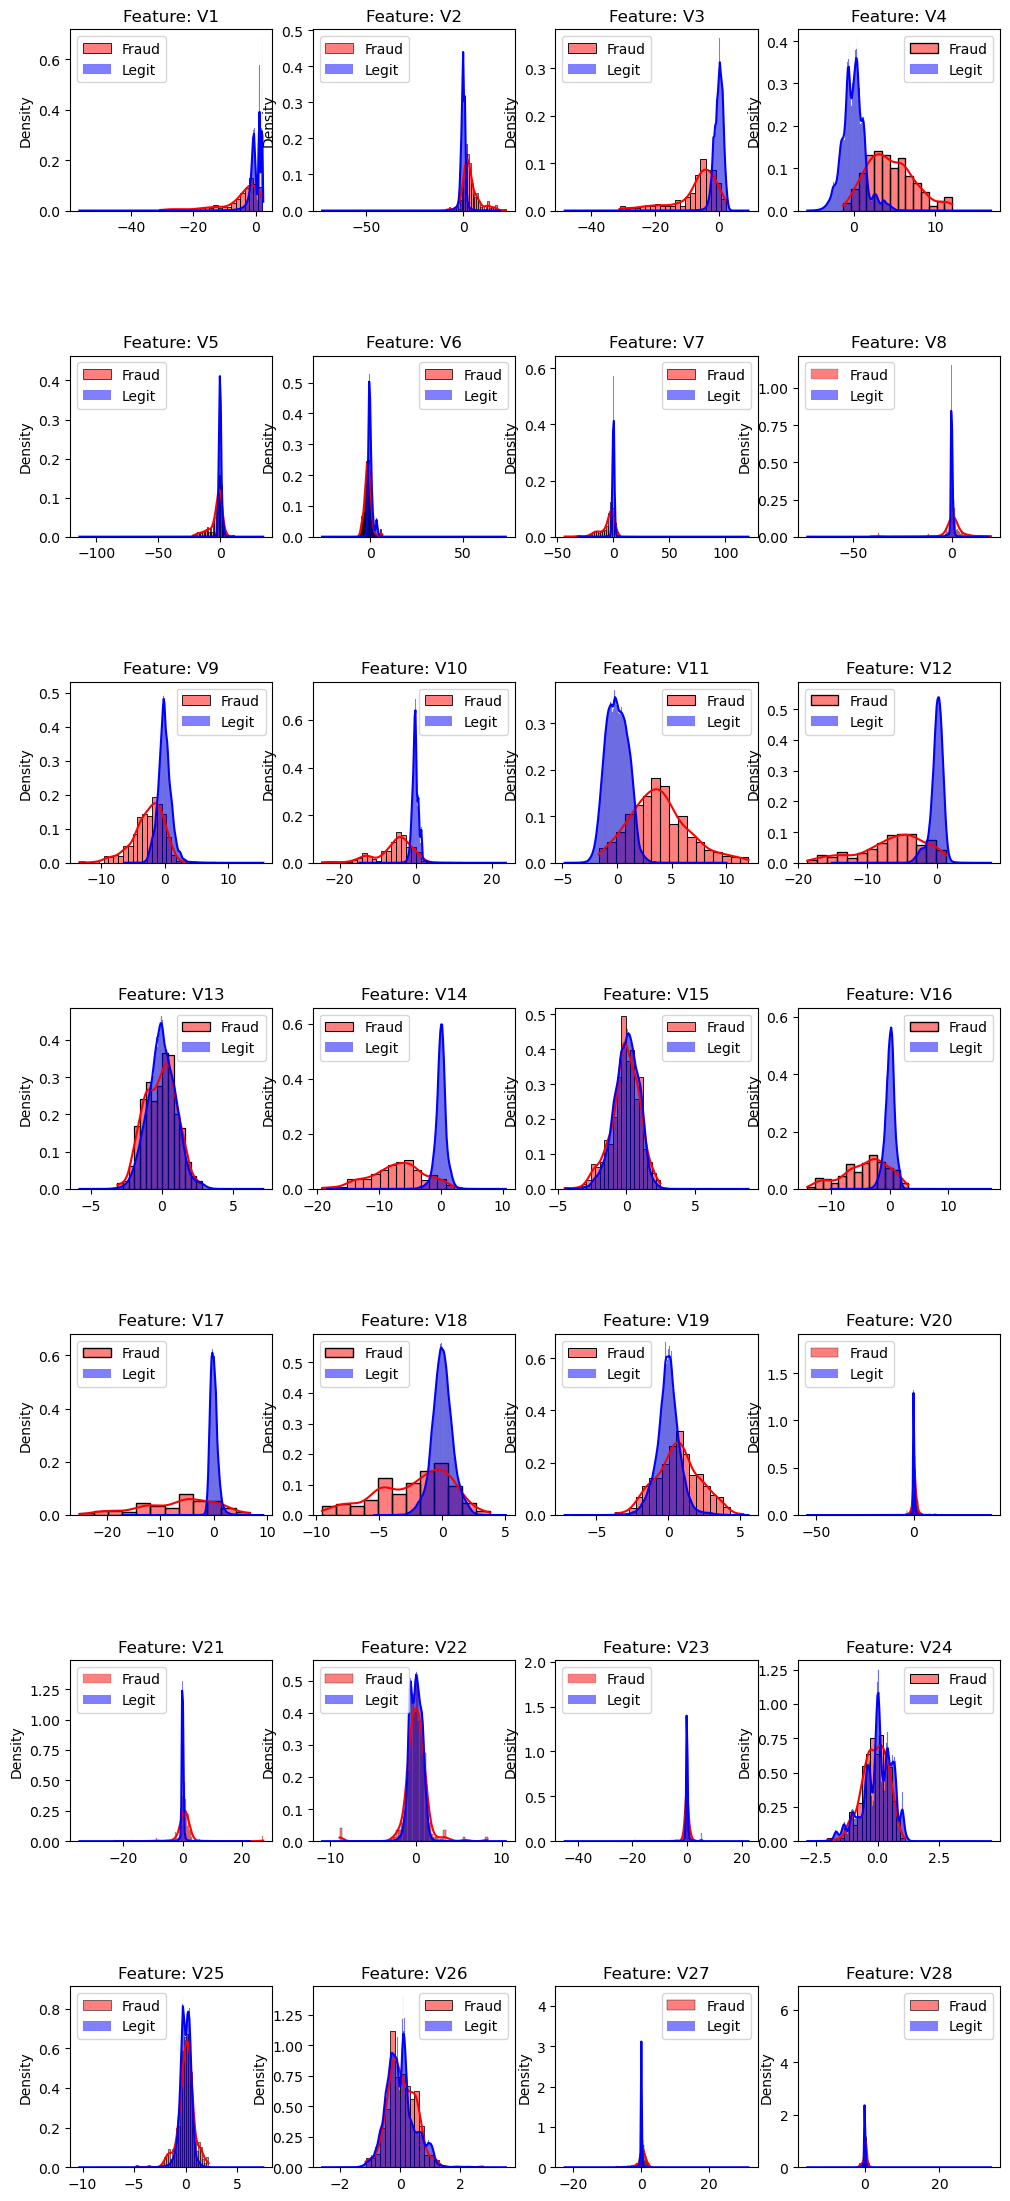

In [60]:
# Representamos gráficamente las características
# Superponemos los elementos de la clase positiva con los de la clase negativa. Esto nos sirve para
# ver si están en el mismo rango y la misma densidad. Por ejemplo V4, V11 diferencian un poquito los valores
# de las distintas clases.

features = df.drop("Class", axis=1)

plt.figure(figsize=(12, 32))
gs = gridspec.GridSpec(8, 4)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    # Usando histplot para los casos donde Class == 1
    sns.histplot(data=df[df["Class"] == 1], x=f, kde=True, color="red", stat="density", label="Fraud", alpha=0.5)
    # Usando histplot para los casos donde Class == 0
    sns.histplot(data=df[df["Class"] == 0], x=f, kde=True, color="blue", stat="density", label="Legit", alpha=0.5)
    ax.set_xlabel('')
    ax.set_title(f"Feature: {f}")
    ax.legend()

plt.show()

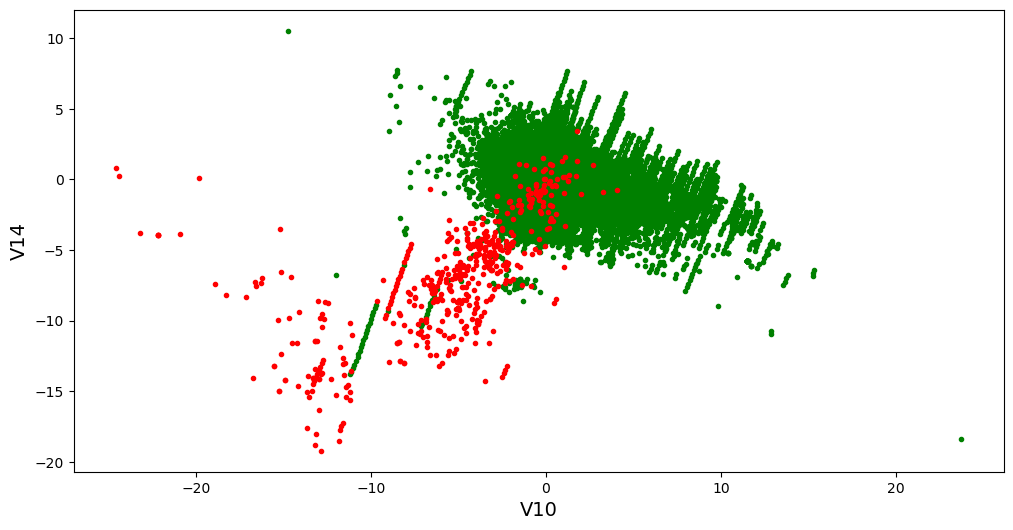

In [61]:
# Representación gráfica de dos características que representan bien ejemplos de una clase u otra
plt.figure(figsize=(12, 6))
plt.scatter(df["V10"][df['Class'] == 0], df["V14"][df['Class'] == 0], c="g", marker=".")
plt.scatter(df["V10"][df['Class'] == 1], df["V14"][df['Class'] == 1], c="r", marker=".")
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

## 3. Preparación del conjunto de datos

Para este tipo de algoritmos es importante que todos los datos se encuentren en un rango similar, por lo tanto, podemos aplicar una función de escalado o normalización. Otra opción, es eliminar las características que no se encuentran en un rango similar siempre y cuando no sean muy influyentes para la predicción.

In [62]:
df = df.drop(["Time", "Amount"], axis=1)

KeyError: "['Time', 'Amount'] not found in axis"

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 29 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

## 4. Kmeans con un conjunto de datos de dos dimensiones

Antes de comenzar con el entrenamiento de KMEANS para todos los atributos del conjunto de datos, se realiza una prueba para dos atributos con el objetivo de comprender como construye el límite de decisión.

In [65]:
X = df[["V10", "V14"]].copy()
X

,V10,V14
0,0.090794,-0.311169
1,-0.166974,-0.143772
2,0.207643,-0.165946
3,-0.054952,-0.287924
4,0.753074,-1.119670
...,...,...
284802,4.356170,4.626942
284803,-0.975926,-0.675143
284804,-0.484782,-0.510602
284805,-0.399126,0.449624


In [66]:
# Generamos los clusters para nuestro conjunto de datos sin etiquetar
from sklearn.cluster import KMeans
# Le pasamos entre 2 y 3 veces más el valor de la etiqueta que presuponemos
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X)

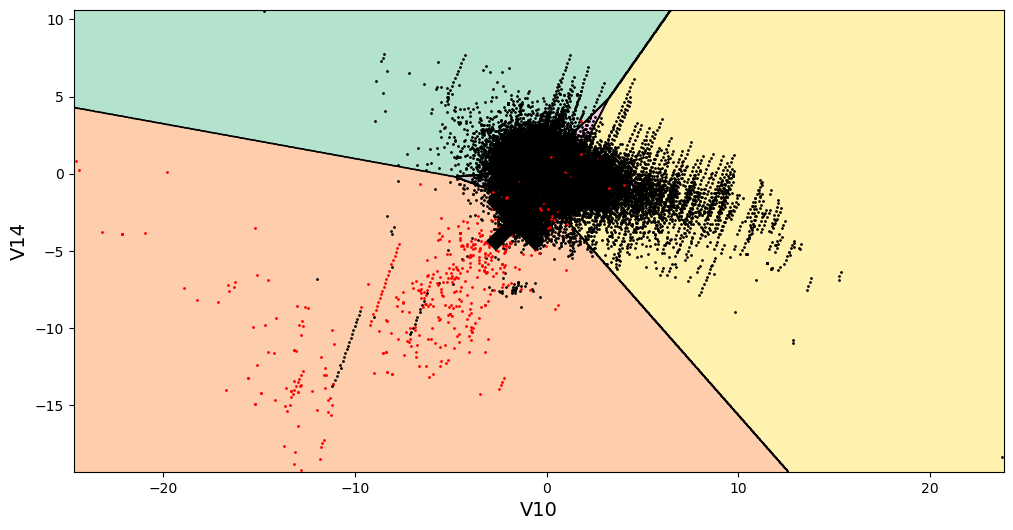

In [67]:
plt.figure(figsize=(12, 6))
plot_decision_boundaries(kmeans, X.values, df["Class"].values)
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

In [57]:
counter = Counter(clusters.tolist())
bad_counter = Counter(clusters[df['Class'] == 1].tolist())

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples - {2} are malicious samples".format(
        key, counter[key], bad_counter[key]))
# esto nos sirve para empezar a analizar por los cluster más pequeñitos

Label 0 has 48659 samples - 6 are malicious samples
Label 1 has 5631 samples - 429 are malicious samples
Label 2 has 121724 samples - 18 are malicious samples
Label 3 has 27404 samples - 8 are malicious samples
Label 4 has 81389 samples - 31 are malicious samples


## 5. Kmeans con un conjunto de datos multidimensional

Al tratarse de un algoritmo basado en aprendizaje no supervisado, no se requieren las etiquetas para entrenar o predir. Hay que tener en cuenta que en este tipo de problemas se presupone que no se dispone de las etiquetas.

In [68]:
X = df.drop("Class", axis=1)
y = df["Class"].copy()

In [69]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X)

In [70]:
# Evaluamos los clusters y el contenido que se han formado
counter = Counter(clusters.tolist())
bad_counter = Counter(clusters[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples - {2} are malicious samples".format(
        key, counter[key], bad_counter[key]))
# Se ha comportado peor con más dimemnsionalidad

Label 0 has 44522 samples - 228 are malicious samples
Label 1 has 100946 samples - 81 are malicious samples
Label 2 has 17163 samples - 0 are malicious samples
Label 3 has 3630 samples - 129 are malicious samples
Label 4 has 118546 samples - 54 are malicious samples


## 6. Reducción del número de características

En muchas ocasiones Kmeans funciona mejor con un número de características bajo.

### Aplicamos selección de características con _Random Forest_

In [71]:
# Utilizamos Random Forest para realizar selección de características
from sklearn.ensemble import RandomForestClassifier

clf_rnd = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
clf_rnd.fit(X, y)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [72]:
# Seleccionamos las características más importantes
feature_importances = {name: score for name, score in zip(list(df), clf_rnd.feature_importances_)}
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)
feature_importances_sorted

V17    0.227702
V14    0.135830
V16    0.081211
V12    0.070265
V10    0.068191
V11    0.053637
V18    0.042195
V4     0.025241
V9     0.024923
V7     0.024014
V26    0.019310
V21    0.018448
V8     0.018000
V3     0.017240
V2     0.016316
V1     0.015399
V20    0.014892
V27    0.014648
V5     0.013940
V19    0.013333
V28    0.011940
V24    0.011790
V25    0.011490
V6     0.011390
V15    0.010828
V13    0.010803
V22    0.009560
V23    0.007465
dtype: float64

In [73]:
# Reducimos el conjunto de datos a las 7 características más importantes
X_reduced = X[list(feature_importances_sorted.head(7).index)].copy()

In [74]:
X_reduced

,V17,V14,V16,V12,V10,V11,V18
0,0.207971,-0.311169,-0.470401,-0.617801,0.090794,-0.551600,0.025791
1,-0.114805,-0.143772,0.463917,1.065235,-0.166974,1.612727,-0.183361
2,1.109969,-0.165946,-2.890083,0.066084,0.207643,0.624501,-0.121359
3,-0.684093,-0.287924,-1.059647,0.178228,-0.054952,-0.226487,1.965775
4,-0.237033,-1.119670,-0.451449,0.538196,0.753074,-0.822843,-0.038195
...,...,...,...,...,...,...,...
284802,1.991691,4.626942,1.107641,2.711941,4.356170,-1.593105,0.510632
284803,-0.025693,-0.675143,-0.711757,0.915802,-0.975926,-0.150189,-1.221179
284804,0.313502,-0.510602,0.140716,0.063119,-0.484782,0.411614,0.395652
284805,0.509928,0.449624,-0.608577,-0.962886,-0.399126,-1.933849,1.113981


### Entrenamiento de KMEANS con el conjunto de datos reducido

In [75]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_reduced)

In [76]:
# Evaluamos los clusters y el contenido que se han formado
counter = Counter(clusters.tolist())
bad_counter = Counter(clusters[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples - {2} are malicious samples".format(
        key, counter[key], bad_counter[key]))
# El cluster 3 es bastante puro
# Este algoritmo funciona mejor con menos dimensionalidad

Label 0 has 109253 samples - 19 are malicious samples
Label 1 has 124538 samples - 17 are malicious samples
Label 2 has 30408 samples - 161 are malicious samples
Label 3 has 308 samples - 265 are malicious samples
Label 4 has 20300 samples - 30 are malicious samples


## 7. Evaluación de los resultados

Hay que tener cuidado con los conjuntos de datos desequilibrados cuando se utilizan métricas para medir la pureza de los clusters. Una posible solución es utilizar técnicas de equilibrado del conjunto de datos, como la generación de más ejemplos de transacciones fraudulentas o la disminución de ejemplos de transacciones legítimas.

In [77]:
# Calculamos el purity score, es importante darse cuenta de que recibe las etiquetas
print("Purity Score:", purity_score(y, clusters))

Purity Score: 0.9990519895929524


In [78]:
# Calculamos el coeficiente de Shiloutte, es importante darse cuenta de que no le pasamos las etiquetas
print("Shiloutte: ", metrics.silhouette_score(X_reduced, clusters, sample_size=10000))

Shiloutte:  0.1789144270951901


In [79]:
# Calculamos el Calinski harabasz score, es importante darse cuenta de que no le pasamos las etiquetas
print("Calinski harabasz: ", metrics.calinski_harabasz_score(X_reduced, clusters))

Calinski harabasz:  38466.001407022675


Nos da una pureza muy buena pero porque tenemos los datos muy desequilibrados... y por eso quedan puros casi siempre... en este caso es poco útil esta métrica.

El coeficiente de Shiloutte que está comprendido entre -1 y 1 y el resultado es aceptable.

El índice Calinski no nos da un valor de referencia, cuanto mayor sea, mejor se comporta pero sólo nos ayuda si comparamos con otros algoritmos.